## Setup

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
from skbio.stats.composition import ilr
from skbio.stats.composition import clr
from skbio.stats.composition import multiplicative_replacement
import seaborn as sns
from matplotlib import rcParams
sns.set()
sns.set(font_scale=1.5)

In [2]:
partial0 = pd.read_csv('data/healthyPCor.csv')
partial1 = pd.read_csv('data/schizoPCor.csv')

In [3]:
table = pd.read_csv('data/genus-table-final.csv', header=0)
table.rename({'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__rc4-4':'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Peptococcaceae;g__rc4;4', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Tissierellaceae;g__1-68':'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Tissierellaceae;g__1;68','k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Tissierellaceae;g__GW-34':'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Tissierellaceae;g__GW;34','k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__p-75-a5':'k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__p;75;a5'}, axis=1, inplace=True)
table0 = table[table['diagnosis']==0]
table1 = table[table['diagnosis']==1]

taxonomy = pd.read_csv('data/taxonomy1.csv', header=0).set_index('Genera')

## Create Networks

In [4]:
#Takes in the partial correlation matrix pulls top triangle and returns associations that are not 0 or -1
def allAssociations(df):
    df2 = df.copy()
    df3 = df2.drop(columns=['Unnamed: 0']).copy()
    indexRename = {}
    count = 0
    
    for column in df3.columns:
        indexRename[count] = column
        count+=1
        
    df3.rename(index=indexRename, inplace=True)

    df4 = df3.where(np.triu(np.ones(df3.shape)).astype(bool))
    df4 = df4.stack().reset_index()
    df4.columns = ['Node1','Node2','Association_Weight']
    
    for i in df4.index:
        if df4.at[i,'Association_Weight'] == -1.0:
            df4.drop(index=i, inplace=True)
            
    return(df4)

In [5]:
asso0 = allAssociations(partial0)
asso1 = allAssociations(partial1)
asso0

,Node1,Node2,Association_Weight
1,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,k__Bacteria.p__Synergistetes.c__Synergistia.o_...,0.0
2,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,k__Bacteria.p__Actinobacteria.c__Actinobacteri...,0.0
3,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,k__Bacteria.p__Proteobacteria.c__Betaproteobac...,0.0
4,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,0.0
5,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactob...,0.0
...,...,...,...
5042,k__Bacteria.p__Firmicutes.c__Erysipelotrichi.o...,k__Bacteria.p__Firmicutes.c__Erysipelotrichi.o...,0.0
5043,k__Bacteria.p__Firmicutes.c__Erysipelotrichi.o...,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactob...,0.0
5045,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,k__Bacteria.p__Firmicutes.c__Erysipelotrichi.o...,0.0
5046,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactob...,0.0


In [6]:
import networkx as nx
import numpy as np
from scipy import integrate

def createSparseGrowthNetworkSpecies(partialdf, abundanceDF):
    G = nx.Graph()
       
    for node in list(set(list(partialdf['Node1']) + list(partialdf['Node2']))):
        family = taxonomy.at[node.replace(".",";").strip(), 'Family']
        if isinstance(family, pd.Series):
            family = family.iloc[0].strip()
        G.add_node(node.replace(".",";").strip(), relativeAbundance=abundanceDF[node.replace(".",";").strip()].mean(), family=family)
        # , genera=generaFindDF_master.at[node.replace(".","-").strip(), 'Genus'].strip())
    
    for row in partialdf.index:
        if abs(partialdf.at[row, 'Association_Weight']) > 0.01:
            G.add_edge(partialdf.at[row, 'Node1'].replace(".",";").strip(),partialdf.at[row,'Node2'].replace(".",";").strip(), weight=partialdf.at[row, "Association_Weight"])
        else:
            continue
        
    return G;

In [7]:
network0 = createSparseGrowthNetworkSpecies(asso0, table0)
network1 = createSparseGrowthNetworkSpecies(asso1, table1)

## Network Properties

In [8]:
def compareAllEdges(network1, network2, listt):
    
    columnNames = listt
    allEdges_Refined = []
    
    for (u, v, c) in network1.edges.data():
        tempList = sorted([u,v])
        if str(tempList[0]+"<-->"+tempList[1]) in allEdges_Refined:
            continue
        else:
            allEdges_Refined.append(str(tempList[0]+"<-->"+tempList[1]))
            
    for (u, v, c) in network2.edges.data():
        tempList = sorted([u,v])
        if str(tempList[0]+"<-->"+tempList[1]) in allEdges_Refined:
            continue
        else:
            allEdges_Refined.append(str(tempList[0]+"<-->"+tempList[1]))
            
            
    #Create a dataframe with all edges and see how many are found in each network
    allNodesDF = pd.DataFrame(index=allEdges_Refined, columns=columnNames)
    #allNodesDF.fillna(0, inplace=True)
    
    for (u, v, c) in network1.edges.data():
        tempList = sorted([u,v])
        allNodesDF.at[tempList[0]+"<-->"+tempList[1], 'Healthy'] = float(c['weight'])
        
    for (u, v, c) in network2.edges.data():
        tempList = sorted([u,v])
        allNodesDF.at[tempList[0]+"<-->"+tempList[1], 'Schizophrenic'] = float(c['weight'])
    
    
    df2 = allNodesDF.copy()
    return(df2)

In [9]:
def pullEdgeStatsPercentage(df):
    
    df2 = df.copy()
    
    tempDict = {"Network":[], "Total_Associations":[], "Unique_Associations":[], "Shared_Associations":[]}

    for column in df2.columns:
        tempDict['Network'].append(column)
        tempDict['Total_Associations'].append(len(df2[column].dropna()))
        
        rows = list(df2[column].dropna().index)
        
        tempDict['Unique_Associations'].append(int(len(df2.loc[rows])-len(df2.loc[rows].dropna(axis=0, thresh=2))) / len(df2[column].dropna()))
        tempDict['Shared_Associations'].append(int(len(df2.loc[rows].dropna(axis=0, thresh=2))) / len(df2[column].dropna()))
    
    tempdf = pd.DataFrame(data=tempDict).set_index("Network")
    
    return(tempdf)

In [10]:
compEdge = compareAllEdges(network0, network1, ['Healthy','Schizophrenic'])
compEdge
edgeStats = pullEdgeStatsPercentage(compEdge)
edgeStats

,Total_Associations,Unique_Associations,Shared_Associations
Network,,,
Healthy,75,0.666667,0.333333
Schizophrenic,59,0.576271,0.423729


In [11]:
def pullAssociationDistribution(network, cohortname):
    tempDict = {'Association_Weight':[], 'Cohort':[]}
    if len(list(network.edges)) < 1:
        tempDict['Association_Weight'].append(0.0)
        tempDict['Cohort'].append(cohortname)
    else:
        for i in network.edges:
            tempDict['Association_Weight'].append(network.edges[i]['weight'])
            tempDict['Cohort'].append(cohortname)
    pdDF = pd.DataFrame(data=tempDict)
    return(pdDF)

In [12]:
edgeDist0 = pullAssociationDistribution(network0, 'Healthy')
edgeDist1 = pullAssociationDistribution(network1, 'Schizophrenic')
edgeDist = pd.concat([edgeDist0, edgeDist1])

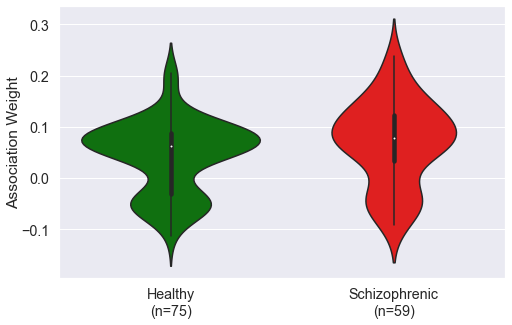

In [51]:
palette ={"Healthy":'green', "Schizophrenic":'red'}

rcParams['figure.figsize'] = 8,5
ax = sns.violinplot(x="Cohort", y="Association_Weight", data=edgeDist, palette=palette)

testList = []
for x in list(ax.get_xticklabels()):
    testList.append(str(str(x.get_text())+"\n"+"(n="+str(len(edgeDist[edgeDist['Cohort']==str(x.get_text())]))+")"))
ax.set_xticklabels(testList)

sns.set(font_scale=1.3)
ax.set_xlabel('',labelpad=15)
ax.set_ylabel('Association Weight', labelpad=0)
# ax.set_title('Cohort Network Association Weight Distributions', pad=10)
plt.savefig('violin.tiff', dpi=300)
plt.show()

In [14]:
from networkx.algorithms.community.quality import modularity

def emergentNetworkProperties(network1, cohortName, partitions):
    columnNames = {"Network":[],  "Nodes":[], "Edges":[], "Positive_Edges":[], "Negative_Edges":[], "Nodes_in_Largest_Component":[], "Single_Nodes":[], "Density":[], "Average_Degree":[], "Average_Betweenness":[], "Modularity":[], "Connectedness":[], "ASPL":[], "Family_Assortativity":[], "Degree_Assortativity":[], "Transitivity":[]}
    ################################################
    columnNames['Network'].append(cohortName)
    columnNames['Nodes'].append(len(network1.nodes))
    columnNames['Edges'].append(len(network1.edges))
    ################################################
    positiveEdges = []
    negativeEdges = [] 
    
    weights = nx.get_edge_attributes(network1, 'weight')
    
    for edge in list(network1.edges):
        if float(weights[edge]) > 0.0:
            positiveEdges.append(weights[edge])               
        else:
            negativeEdges.append(weights[edge])
            
    columnNames['Positive_Edges'].append(len(positiveEdges))
    columnNames['Negative_Edges'].append(len(negativeEdges))
    
    #Find average degree of all nodes
    degrees = []
    for i in network1.nodes:
        degrees.append(network1.degree(i))
    avgDeg = np.mean(degrees)
    columnNames['Average_Degree'].append(avgDeg)

    # Betweenness Centrality
    betweenness = nx.betweenness_centrality(network1, weight='weight')
    avgBet = np.mean(list(betweenness.values()))
    columnNames['Average_Betweenness'].append(avgBet)
    
    #Find Average Shortest Path Length (Average of over all connected components)
    Gcc = sorted(nx.connected_components(network1), key=len, reverse=True)
    L2 = []
    for g in Gcc:
        if len(g) > 1:
            G0 = network1.subgraph(g)
            L2.append(nx.average_shortest_path_length(G0))
        else:
            continue
            weight=None
            
    columnNames['ASPL'] = np.mean(L2)
    
    columnNames['Modularity'].append(modularity(network1, partitions))
    
    #Find out how many nodes have no connections
    counttt = 0
    for i in list(nx.connected_components(network1)):
        if len(i) >1:
            continue
        else:
            counttt+=1
    columnNames['Single_Nodes'] = counttt
    
    #Find how many nodes are in the biggest component of the graph
    networkComponents = sorted(nx.connected_components(network1), key=len, reverse=True)
    bigcomponent = network1.subgraph(networkComponents[0])
    columnNames['Nodes_in_Largest_Component'] = len(list(nx.connected_components(bigcomponent))[0])
    
    
    ###################################################################################
    #Some statistics only work on connected components. Check if the network is connected.
    if nx.is_connected(network1):
        columnNames['Connectedness'].append("True")
        columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(network1))
        columnNames['Transitivity'].append(nx.transitivity(network1))
        columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(network1))
        columnNames['Family_Assortativity'].append(nx.attribute_assortativity_coefficient(network1, 'family'))
        columnNames['Transitivity'].append(nx.transitivity(network1))
        columnNames['Density'].append(nx.density(network1))
    else:
        columnNames['Connectedness'].append("False")
        columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(network1))
        columnNames['Family_Assortativity'].append(nx.attribute_assortativity_coefficient(network1, 'family'))
        columnNames['Transitivity'].append(nx.transitivity(network1))
        columnNames['Density'].append(nx.density(network1))
        
    cohortDF = pd.DataFrame(columnNames)
    return(cohortDF)

In [15]:
from networkx.algorithms.community.label_propagation import asyn_lpa_communities
partition0 = list(asyn_lpa_communities(network0, weight='weight'))
partition1 = list(asyn_lpa_communities(network1, weight='weight'))

In [16]:
networkProperty0 = emergentNetworkProperties(network0, "Healthy", partition0).set_index("Network")
networkProperty1 = emergentNetworkProperties(network1, "Schizophrenic", partition1).set_index("Network")
networkProperty = pd.concat([networkProperty0, networkProperty1])

In [17]:
networkProperty

,Nodes,Edges,Positive_Edges,Negative_Edges,Nodes_in_Largest_Component,Single_Nodes,Density,Average_Degree,Average_Betweenness,Modularity,Connectedness,ASPL,Family_Assortativity,Degree_Assortativity,Transitivity
Network,,,,,,,,,,,,,,,
Healthy,100,75,54,21,23,73,0.015152,1.50,0.003225,0.393715,False,1.359684,0.001984,0.113308,0.601010
Schizophrenic,100,59,45,14,23,66,0.011919,1.18,0.001668,0.688413,False,1.276899,0.134777,0.150763,0.511945


In [18]:
def nodeAndEdgeStats(network1, abundanceDF, cohortName, level):

    columnNames = {"Bacterial_"+level:[], "Mean_Relative_Abundance":[],"Total_Edges":[], "Positive_Edges":[], "Negative_Edges":[], "Triangles":[], "Degree_Centrality":[], "Clustering_Coefficient":[], "Harmonic_Centrality":[], "Betweenness_Centrality":[], "Cohort":[]}

    triangles = nx.triangles(network1)
    
    dcentrality = nx.degree_centrality(network1)
    
    hcentrality = nx.harmonic_centrality(network1)
        
    bcentrality = nx.betweenness_centrality(network1, normalized=True)
    
    nodes = network1.nodes
    
    weights = nx.get_edge_attributes(network1, 'weight')
    
    clusteringc = nx.clustering(network1)
    
    for i in nodes:
        
        positiveEdges = []
        negativeEdges = []
        totalEdges = []
        
        for edge in network1.edges:
            if edge[0] == i or edge[1] == i:
                if weights[edge] > 0.0:
                    positiveEdges.append(weights[edge])
                    totalEdges.append(weights[edge])
                else:
                    totalEdges.append(weights[edge])
                    negativeEdges.append(weights[edge])
            else:
                continue
        
        columnNames['Bacterial_'+level].append(i)
        columnNames['Clustering_Coefficient'].append(clusteringc[i])
        columnNames['Mean_Relative_Abundance'].append(abundanceDF[i].mean())
        columnNames['Total_Edges'].append(len(totalEdges))
        columnNames['Positive_Edges'].append(len(positiveEdges))
        columnNames['Negative_Edges'].append(len(negativeEdges))
        columnNames['Triangles'].append(triangles[i])
        columnNames['Degree_Centrality'].append(dcentrality[i])
        columnNames['Harmonic_Centrality'].append(hcentrality[i])
        columnNames['Betweenness_Centrality'].append(bcentrality[i])
        columnNames['Cohort'].append(cohortName)

    cohortDF = pd.DataFrame(data=columnNames).set_index("Bacterial_"+level)
    return(cohortDF)

In [19]:
nodeDF0 = nodeAndEdgeStats(network0, table0, "Healthy", "Genus")
nodeDF1 = nodeAndEdgeStats(network1, table1, "Schizophrenic", "Genus")

In [20]:
nodeDF0

,Mean_Relative_Abundance,Total_Edges,Positive_Edges,Negative_Edges,Triangles,Degree_Centrality,Clustering_Coefficient,Harmonic_Centrality,Betweenness_Centrality,Cohort
Bacterial_Genus,,,,,,,,,,
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella,0.103148,0,0,0,0,0.000000,0.000000,0.000000,0.000000,Healthy
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__02d06,0.000336,0,0,0,0,0.000000,0.000000,0.000000,0.000000,Healthy
k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Synergistes,0.000004,3,2,1,1,0.030303,0.333333,10.916667,0.004329,Healthy
k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus,0.000062,0,0,0,0,0.000000,0.000000,0.000000,0.000000,Healthy
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia,0.000018,0,0,0,0,0.000000,0.000000,0.000000,0.000000,Healthy
...,...,...,...,...,...,...,...,...,...,...
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes,0.016252,0,0,0,0,0.000000,0.000000,0.000000,0.000000,Healthy
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Aggregatibacter,0.000077,5,2,3,3,0.050505,0.300000,12.500000,0.005109,Healthy
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Paraprevotellaceae;g__Prevotella,0.005011,3,0,3,3,0.030303,1.000000,10.750000,0.000000,Healthy


In [21]:
from networkx.algorithms.community.quality import performance
print("Healthy Module Detection Performance: "+str(performance(network0, partition0)))
print("Schizophrenic Module Detection Performance: "+str(performance(network1, partition1)))

Healthy Module Detection Performance: 0.9761616161616161
Schizophrenic Module Detection Performance: 0.9917171717171717


## Graph Networks

In [22]:
edgeColorList0 = []
for x in list(network0.edges(data=True)):
    if float(x[2]['weight']) > 0:
        edgeColorList0.append('green')
    else:
        edgeColorList0.append('red')
        
edgeColorList1 = []
for x in list(network1.edges(data=True)):
    if float(x[2]['weight']) > 0:
        edgeColorList1.append('green')
    else:
        edgeColorList1.append('red')

In [76]:
nodeList = network0.nodes()
nodeList = [i for i in nodeList]
nodeList.sort()
nodeSize0 = []
nodeSize1 = []
# print(nodeList)

for i in nodeList:
    nodeSize0.append(float(network0.degree(i)+0.2)*8)
    nodeSize1.append(float(network1.degree(i)+0.2)*8)

In [24]:
phylum = set()
for i in nodeList:
    p = taxonomy.at[i,'Phylum']
    if isinstance(p, pd.Series):
        p = p.iloc[0].strip()
    phylum.add(p)
print(phylum)

{'p__Synergistetes', 'p__Bacteroidetes', 'p__Euryarchaeota', 'p__Actinobacteria', 'p__Proteobacteria', 'p__Firmicutes'}


In [25]:
nodeColor = {}
for i in nodeList:
    if 'p__Firmicutes' in i:
        nodeColor[i]="green"
    elif 'p__Proteobacteria' in i:
        nodeColor[i]="blue"
    elif 'p__Synergistetes' in i:
        nodeColor[i]="purple"
    elif 'p__Actinobacteria' in i:
        nodeColor[i]="red"
    elif 'p__Bacteroidetes' in i:
        nodeColor[i]="orange"
    elif 'p__Euryarchaeota' in i:
        nodeColor[i]="yellow"

In [26]:
Phylumlegend = {"Actinobacteria":"red","Bacteroidetes":"orange","Euryarchaeota":"yellow","Firmicutes":"green","Proteobacteria":"blue","Synergistetes":"purple"}

In [27]:
degrees0 = nx.degree_centrality(network0)
degrees1 = nx.degree_centrality(network1)

degrees0 = {k: v for k, v in degrees0.items() if v > 0.05}
degrees1 = {k: v for k, v in degrees1.items() if v > 0.05}
hub_nodes = set(list(degrees0.keys()))
hub_nodes.update(list(degrees1.keys()))
hub_nodes = sorted(list(hub_nodes))
len(hub_nodes)

nodes2nums = {hub_nodes[i]: i+1 for i in range(len(hub_nodes))}
nodes2nums0 = {k: v for k, v in nodes2nums.items() if k in degrees0.keys()}
nodes2nums1 = {k: v for k, v in nodes2nums.items() if k in degrees1.keys()}

In [28]:
hub_nodes

['k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Roseburia',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus',
 'k__Bacteria;p__Firmicutes;c__Clostridia;o__C

In [29]:
# degree_difference = {}
# for node in degrees0.keys():
#     degree_difference[node] = abs(degrees0[node]-degrees1[node])
# degree_difference = dict(sorted(degree_difference.items(), key=lambda item: item[1], reverse=True))
# degree_difference = {x: v for x, v in degree_difference.items() if v > 0.05}
# degree_difference
# hub_nodes = sorted(list(degree_difference.keys()))
# hub_nums = {hub_nodes[i]:i+1 for i in range(len(degree_difference))}
# print(hub_nodes)

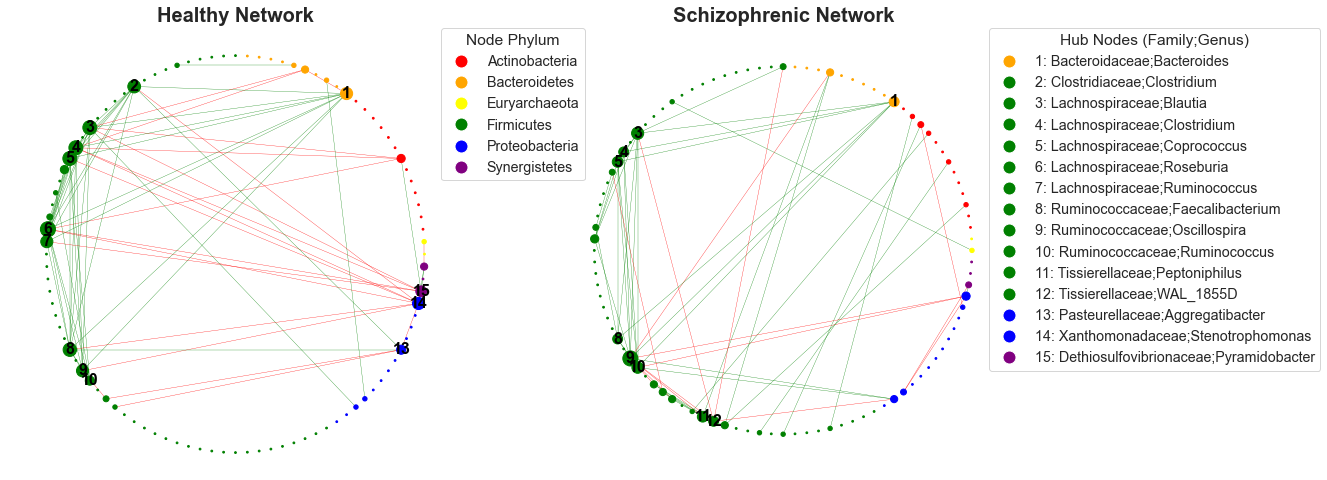

In [30]:
G=nx.grid_2d_graph(2,2)  #4x4 grid
from matplotlib.lines import Line2D

posit = nx.circular_layout(nodeList)
fig, ax = plt.subplots(figsize=(18,18))

ax1 = plt.subplot(221)
nx.draw_networkx_nodes(network0, pos=posit, nodelist=nodeList, node_size=nodeSize0, node_color=list(nodeColor.values()))
nx.draw_networkx_edges(network0, pos=posit, width=.3, edge_color=edgeColorList0)
nx.draw_networkx_labels(network0, pos=posit,horizontalalignment='center', labels=nodes2nums0,font_size=16,font_weight='bold',font_color='black')

plt.title("Healthy Network", fontsize=20, fontweight="bold")
ax.set_facecolor('white')
ax.axis('off')
ax1.set_facecolor('white')

ax2 = plt.subplot(222)
nx.draw_networkx_nodes(network1, pos=posit, nodelist=nodeList, node_size=nodeSize1, node_color=list(nodeColor.values()))
nx.draw_networkx_edges(network1, pos=posit, width=.3, edge_color=edgeColorList1)
nx.draw_networkx_labels(network1,pos=posit, labels=nodes2nums1,font_size=16,font_weight='bold',font_color='black')
plt.title("Schizophrenic Network", fontsize=20, fontweight="bold")
ax2.set_facecolor('white')

lines = [Line2D([0], [0], marker='o', markersize=13, color='white',markerfacecolor=nodeColor[c], linewidth=1) for c in hub_nodes]
labels = [str(i+1)+": "+hub_nodes[i].split("f__")[-1].replace("g__","") for i in range(len(hub_nodes))]
firstLeg = plt.legend(lines, labels, bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0., title='Hub Nodes (Family;Genus)', facecolor='w')

lines2 = [Line2D([0], [0], marker='o', markersize=13, color='white', markerfacecolor=Phylumlegend[c], linewidth=3) for c in list(Phylumlegend.keys())]
labels2 = list(Phylumlegend.keys())
newLeg = plt.legend(lines2, labels2, bbox_to_anchor=(-.25, 1), loc=2, borderaxespad=0., title='Node Phylum', facecolor='w')

plt.gca().add_artist(firstLeg)
plt.show()

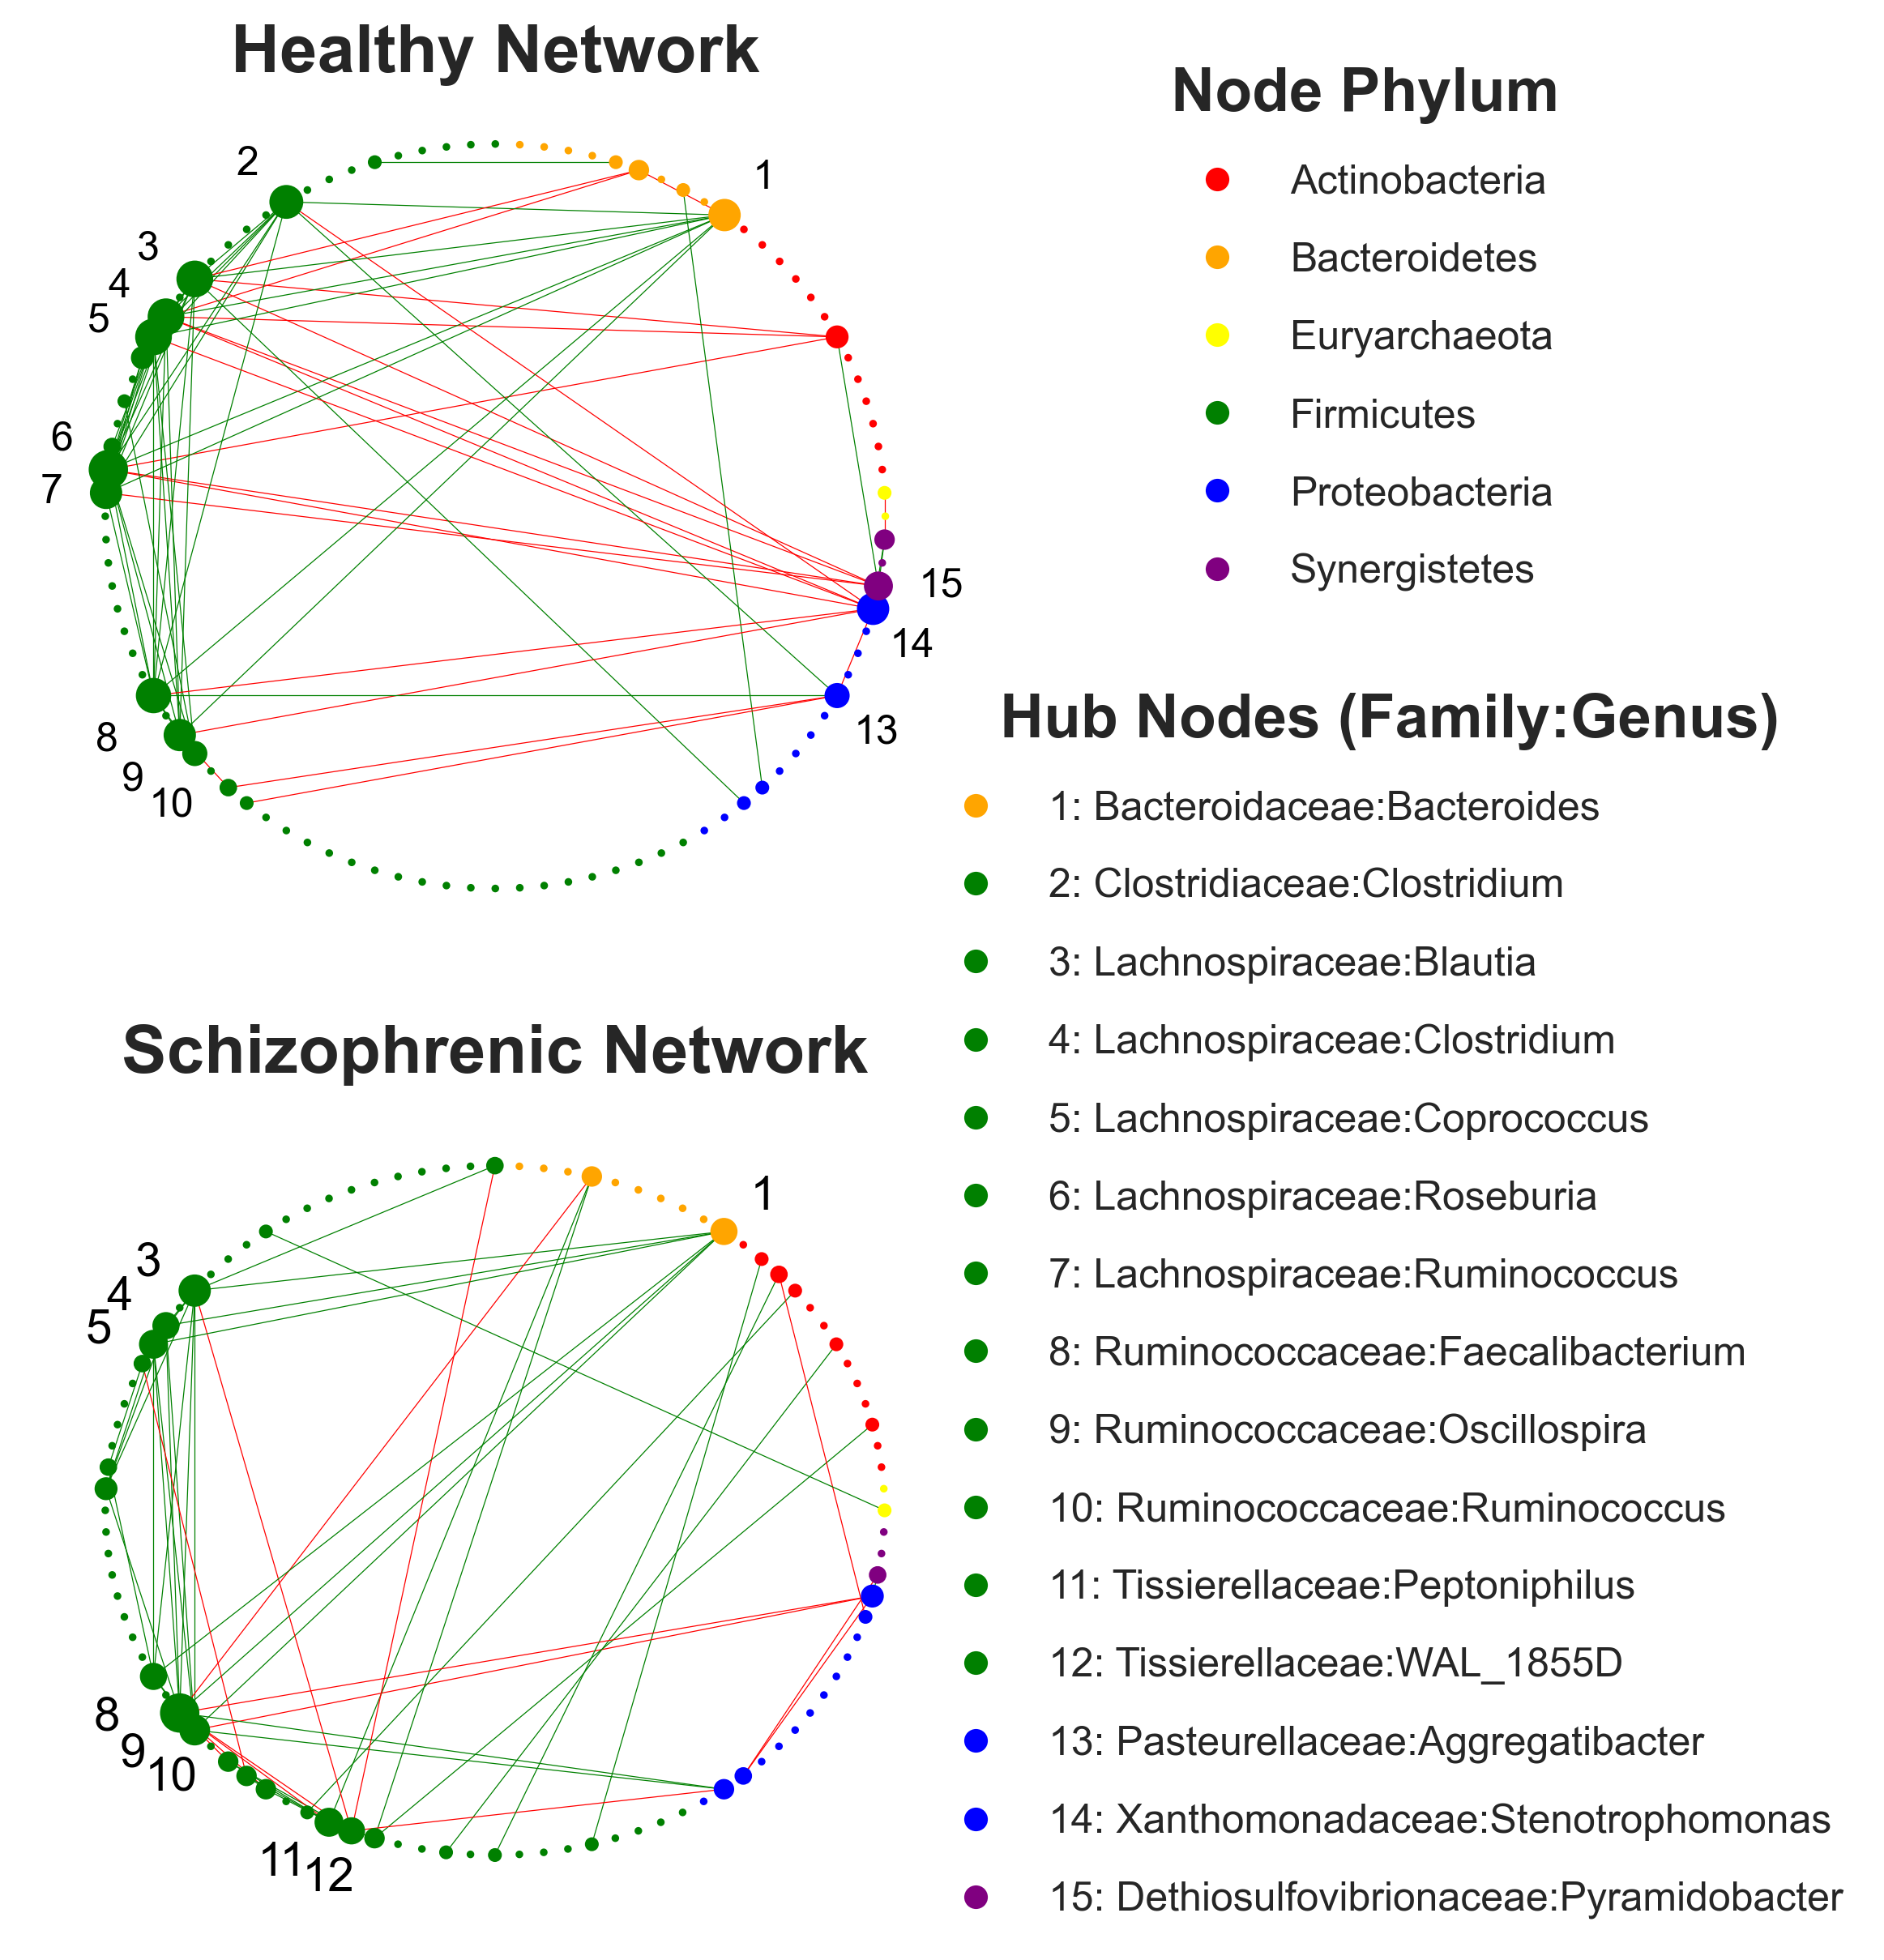

In [81]:
G=nx.grid_2d_graph(2,2)  #4x4 grid
from matplotlib.lines import Line2D
plt.rcParams['figure.dpi'] = 300

posit = nx.circular_layout(nodeList)
fig, ax = plt.subplots(figsize=(5,10))

import copy
position = copy.deepcopy(posit)
for n, coords in list(position.items()):
    if n == hub_nodes[0]:
        coords[0] += 0.1
        coords[1] += 0.1
    elif n == hub_nodes[1]:
        coords[0] -= 0.1
        coords[1] += 0.1
    elif n in [hub_nodes[i] for i in [2,3,5]]:
        coords[0] -= 0.12
        coords[1] += 0.08
    elif n in [hub_nodes[i] for i in [4]]:
        coords[0] -= 0.14
        coords[1] += 0.04
    elif n in [hub_nodes[i] for i in [6]]:
        coords[0] -= 0.14
    elif n in [hub_nodes[i] for i in [7,8,10]]:
        coords[0] -= 0.12
        coords[1] -= 0.12
    elif n in [hub_nodes[i] for i in [9,11]]:
        coords[0] -= 0.06
        coords[1] -= 0.14
    elif n in hub_nodes[12:14]:
        coords[0] += 0.1
        coords[1] -= 0.1
    elif n == hub_nodes[14]:
        coords[0] += 0.16

ax1 = plt.subplot(211)
nx.draw_networkx_nodes(network0, pos=posit, nodelist=nodeList, node_size=nodeSize0, node_color=list(nodeColor.values()))
nx.draw_networkx_edges(network0, pos=posit, width=.3, edge_color=edgeColorList0)
nx.draw_networkx_labels(network0, pos=position,horizontalalignment='center', labels=nodes2nums0,font_size=12,font_color='black')

plt.title("Healthy Network", fontsize=20, fontweight="bold")
ax.set_facecolor('white')
ax.axis('off')
ax1.set_facecolor('white')

ax2 = plt.subplot(212)
nx.draw_networkx_nodes(network1, pos=posit, nodelist=nodeList, node_size=nodeSize1, node_color=list(nodeColor.values()))
nx.draw_networkx_edges(network1, pos=posit, width=.3, edge_color=edgeColorList1)
nx.draw_networkx_labels(network1,pos=position, labels=nodes2nums1,font_size=14,font_color='black')
plt.title("Schizophrenic Network", fontsize=20, fontweight="bold")
ax2.set_facecolor('white')

# plt.rcParams.update({'font.size': 30})
lines = [Line2D([0], [0], marker='o', markersize=8, color='white',markerfacecolor=nodeColor[c], linewidth=1) for c in hub_nodes]
labels = [str(i+1)+": "+hub_nodes[i].split("f__")[-1].replace("g__","").replace(";",":") for i in range(len(hub_nodes))]
firstLeg = plt.legend(lines, labels, bbox_to_anchor=(0.95, 1.5), loc=2, borderaxespad=0., title='Hub Nodes (Family:Genus)', facecolor='w', fontsize=12, labelspacing=1, edgecolor='white')
plt.setp(firstLeg.get_title(),fontsize=18, fontweight='bold')

lines2 = [Line2D([0], [0], marker='o', markersize=8, color='white', markerfacecolor=Phylumlegend[c], linewidth=3) for c in list(Phylumlegend.keys())]
labels2 = list(Phylumlegend.keys())
newLeg = plt.legend(lines2, labels2, bbox_to_anchor=(1.2, 2.25), loc=2, borderaxespad=0., title='Node Phylum', facecolor='w', fontsize=12, labelspacing=1, edgecolor='white')
plt.setp(newLeg.get_title(),fontsize=18, fontweight='bold')

plt.gca().add_artist(firstLeg)
extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig("network1.tiff", dpi=300, bbox_inches='tight')
plt.show()

## Cliques

In [32]:
network0_pos = network0.copy()
network1_pos = network1.copy()

network0_neg = network0.copy()
network1_neg = network1.copy()

In [33]:
for i in list(network0_pos.edges.data()):
    if float(i[2]['weight']) >0:
        continue
    else:
        network0_pos.remove_edge(i[0], i[1])
        
for i in list(network1_pos.edges.data()):
    if float(i[2]['weight']) >0:
        continue
    else:
        network1_pos.remove_edge(i[0], i[1])

In [34]:
for x in list(network0_neg.edges.data()):
    if float(x[2]['weight']) < 0:
        continue
    else:
        network0_neg.remove_edge(x[0], x[1])
        
for x in list(network1_neg.edges.data()):
    if float(x[2]['weight']) < 0:
        continue
    else:
        network1_neg.remove_edge(x[0], x[1])

In [35]:
cliques0 = list(nx.find_cliques(network0))
cliques1 = list(nx.find_cliques(network1))

In [36]:
tempDict = {"Cohort":[], "CliqueSize":[]}
for x in cliques0:
    tempDict['Cohort'].append("Healthy")
    tempDict['CliqueSize'].append(int(len(x)))

for y in cliques1:
    tempDict['Cohort'].append("Schizophrenic")
    tempDict['CliqueSize'].append(int(len(y)))

In [37]:
def returnGoodCliques(network, cliqueSize):
    cliques = []
    for i in list(nx.enumerate_all_cliques(network)):
        if len(i) == cliqueSize:
            cliques.append(i)
    return(cliques)

In [38]:
# Finds the maximal cliques for all networks
def findCliques(network1, network2, name1, name2, cliqueSize):
    
    names = []
    
    allCliques_temp1 = []
    allCliques_temp2 = []

    netNames = {}
    
    if network1 != 'No':
        allCliques_temp1 = returnGoodCliques(network1, cliqueSize)
        names.append(name1)
        netNames[name1]=allCliques_temp1
        
    if network2 != 'No':
        allCliques_temp2 = returnGoodCliques(network2, cliqueSize)    
        names.append(name2)
        netNames[name2]=allCliques_temp2
        
    
    # Set one cohort as all cliques so far then add cliques that are unique from each cohort
    allCliques = allCliques_temp1.copy()

    for i in allCliques_temp2:
        
        countFlag = False
        
        for x in allCliques:
            if sorted(i) == sorted(x):
                countFlag = True
            else:
                continue
                
        if countFlag == False:
            allCliques.append(sorted(i))
        else:
            continue
    
    ####################################################################################
    # BUILD NEW DATAFRAME AND SAY IF ITS IN THAT COHORT OR NOT
    
    clidDic = {"Clique":[], "Healthy":[], "Schizophrenic":[]}
   
    for clique in allCliques:
        
        clidDic['Clique'].append(clique)
        clique1count = False
        clique2count = False
        
        for clique1 in allCliques_temp1:
            
            if sorted(clique1) == sorted(clique):
                clique1count = True
            else:
                continue
                
        if clique1count == True:
            clidDic['Healthy'].append("Present")
        else:
            clidDic['Healthy'].append(np.nan)
        
        ###############################################
        
        for clique2 in allCliques_temp2:
            if sorted(clique2) == sorted(clique):
                clique2count = True
            else:
                continue
                
        if clique2count == True:
            clidDic['Schizophrenic'].append("Present")
        else:
            clidDic['Schizophrenic'].append(np.nan)
            
        ################################################
        

    cliqueDF = pd.DataFrame(data=clidDic).set_index("Clique")
    
    return(cliqueDF)

In [39]:
allCliques = findCliques(network0, network1, 'Healthy', 'Schizophrenic', 3)

In [40]:
weights0 = []
weights1 = []
for i in range(allCliques.shape[0]):
    nodes = allCliques.index[i]
    if pd.isna(allCliques.iat[i,0]):
        weights0.append(np.nan)
    else:
        weight0 = []
        weight0.append(network0.get_edge_data(nodes[0],nodes[1])['weight'])
        weight0.append(network0.get_edge_data(nodes[1],nodes[2])['weight'])
        weight0.append(network0.get_edge_data(nodes[0],nodes[2])['weight'])
        weights0.append(weight0)
    
    if pd.isna(allCliques.iat[i,1]):
        weights1.append(np.nan)
    else:
        weight1 = []
        weight1.append(network1.get_edge_data(nodes[0],nodes[1])['weight'])
        weight1.append(network1.get_edge_data(nodes[1],nodes[2])['weight'])
        weight1.append(network1.get_edge_data(nodes[0],nodes[2])['weight'])
        weights1.append(weight1)

allCliques['Healthy_Weights'] = weights0
allCliques['Schizophrenic_Weights'] = weights1


In [41]:
sharedCliques = allCliques.dropna()
sharedCliques

,Healthy,Schizophrenic,Healthy_Weights,Schizophrenic_Weights
Clique,,,,
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia]",Present,Present,"[0.0659020629486124, 0.0697549521390291, 0.110...","[0.0962005736192263, 0.0771886483822155, 0.131..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira, k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides]",Present,Present,"[0.0659020629486124, 0.0592005099309771, 0.095...","[0.0962005736192263, 0.069457838526631, 0.1610..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus]",Present,Present,"[0.0659020629486124, 0.106404772620569, 0.0875...","[0.0962005736192263, 0.133644588205437, 0.1275..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia, k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides]",Present,Present,"[0.110451623182212, 0.110663810386914, 0.09583...","[0.131883762404216, 0.130063735782361, 0.16102..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus]",Present,Present,"[0.110451623182212, 0.0945534281933926, 0.0750...","[0.131883762404216, 0.0583816829290027, 0.0468..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus]",Present,Present,"[0.110451623182212, 0.0956765191542008, 0.0875...","[0.131883762404216, 0.175649915212152, 0.12752..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus]",Present,Present,"[0.095835730755579, 0.0836572144721347, 0.0875...","[0.161027070814431, 0.0775217812583541, 0.1275..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus]",Present,Present,"[0.0750679795065061, 0.0682265175439164, 0.087...","[0.0468624764354577, 0.0342438916648692, 0.127..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium]",Present,Present,"[0.142239719324774, 0.106430689275067, 0.08672...","[0.167026338606919, 0.0690085177357553, 0.0780..."


In [42]:
rowsToRemove = set()
for i in range(sharedCliques.shape[0]):
    w0 = sharedCliques.iat[i,2]
    w1 = sharedCliques.iat[i,3]
    for j in range(len(w0)):
        if np.sign(w0[j]) != np.sign(w1[j]):
            rowsToRemove.add(i)
            break

if len(rowsToRemove) != 0:
    sharedCliques.drop(list(rowsToRemove),axis=0)
sharedCliques

,Healthy,Schizophrenic,Healthy_Weights,Schizophrenic_Weights
Clique,,,,
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia]",Present,Present,"[0.0659020629486124, 0.0697549521390291, 0.110...","[0.0962005736192263, 0.0771886483822155, 0.131..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira, k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides]",Present,Present,"[0.0659020629486124, 0.0592005099309771, 0.095...","[0.0962005736192263, 0.069457838526631, 0.1610..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus]",Present,Present,"[0.0659020629486124, 0.106404772620569, 0.0875...","[0.0962005736192263, 0.133644588205437, 0.1275..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia, k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides]",Present,Present,"[0.110451623182212, 0.110663810386914, 0.09583...","[0.131883762404216, 0.130063735782361, 0.16102..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus]",Present,Present,"[0.110451623182212, 0.0945534281933926, 0.0750...","[0.131883762404216, 0.0583816829290027, 0.0468..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Blautia, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus]",Present,Present,"[0.110451623182212, 0.0956765191542008, 0.0875...","[0.131883762404216, 0.175649915212152, 0.12752..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus]",Present,Present,"[0.095835730755579, 0.0836572144721347, 0.0875...","[0.161027070814431, 0.0775217812583541, 0.1275..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus]",Present,Present,"[0.0750679795065061, 0.0682265175439164, 0.087...","[0.0468624764354577, 0.0342438916648692, 0.127..."
"[k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira, k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium]",Present,Present,"[0.142239719324774, 0.106430689275067, 0.08672...","[0.167026338606919, 0.0690085177357553, 0.0780..."


## Random Network Comparison

In [43]:
#Erdos-Renyi Random Networks
from tqdm import tqdm
import numpy as np
from networkx.algorithms.community.label_propagation import asyn_lpa_communities
from networkx.algorithms.community.quality import modularity
from networkx.generators.random_graphs import erdos_renyi_graph
from random import shuffle

def createRandom(network):
    
    columnNames = {"ASPL":[],"Average_Degree":[], "Modularity":[], "Average_Clustering_Coefficient":[],"Abundance_Assortativity":[],"Family_Assortativity":[], "Degree_Assortativity":[],"Transitivity":[]}
        
    n = len(network.nodes)
    p = nx.density(network)
    
    generaList = []
    for x in list(network.nodes(data='family')):
        generaList.append(x[1])
        
    abundanceList = []
    for y in list(network.nodes(data='relativeAbundance')):
        abundanceList.append(y[1])
        
    
    seedNum = 101
    for i in tqdm(range(1000)):
        
        G = nx.erdos_renyi_graph(n, p, seed=seedNum)
        
        randomPartitions = list(asyn_lpa_communities(G))
        columnNames['Modularity'].append(modularity(G, randomPartitions))
              
        generaList2 = generaList
        shuffle(generaList2)
        
        abundanceList2 = abundanceList
        shuffle(abundanceList2)
        
        j = 0
        for node in G.nodes:
            G.nodes[node]['relativeAbundance'] = abundanceList2[j]
            G.nodes[node]['family'] = generaList2[j]
            j+=1
        
        if nx.is_connected(G):
            degreeList = [d for v, d in G.degree()]
            columnNames['Average_Degree'].append(np.mean(degreeList))
            
            columnNames['ASPL'].append(nx.average_shortest_path_length(G))
            columnNames['Average_Clustering_Coefficient'].append(nx.average_clustering(G))
            columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(G))
            columnNames['Transitivity'].append(nx.transitivity(G))
            columnNames['Abundance_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'relativeAbundance'))
            columnNames['Family_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'family'))
        else:
            #IF the network is not connected then take the largest connected component and run stats.
            Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
            L2 = []
            for sub in Gcc:
                if len(sub) > 1:
                    sub0 = G.subgraph(sub)
                    L2.append(nx.average_shortest_path_length(sub0))
                else:
                    continue
                    
                    
            degreeList = [d for v, d in G.degree()]
            columnNames['Average_Degree'].append(np.mean(degreeList))
    
            columnNames['ASPL'].append(np.mean(L2))
            columnNames['Average_Clustering_Coefficient'].append(nx.average_clustering(G))
            columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(G))
            columnNames['Transitivity'].append(nx.transitivity(G))
            columnNames['Abundance_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'relativeAbundance'))
            columnNames['Family_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'family'))
        ####################################################################################   
        seedNum+=1
        
    dataF = pd.DataFrame(data=columnNames)
    return(dataF)

In [44]:
random0 = createRandom(network0)
random1 = createRandom(network1)

100%|██████████| 1000/1000 [00:12<00:00, 78.52it/s]


In [45]:
def MonteCarloSimulationPvalues(model1, globaldf, networkName):
    
    ModeDict = ["Erdos-Renyi"]
    
    dfList2 = {"Model":[], "ASPL":[], "Family_Assortativity":[], "Degree_Assortativity":[], "Transitivity":[],"Modularity":[]}
    keyss = list(dfList2.keys())
    keyss.pop(0)
    dfList3 = dfList2.copy()
    
    for model in ModeDict:
        
        if model == 'Erdos-Renyi':
            modelCompDF = model1.copy()
            
        dfList2["Model"].append(model)
        dfList3["Model"].append(model)

        
        for key in keyss:
            
            #Test to see if the value is greater or smaller than the models mean:
            
            if globaldf.at[networkName, key] > modelCompDF[key].mean():
                #Count how many times the real network was less then the model values
                myCountLarge = 0
                for row in modelCompDF.index:
                    if modelCompDF.at[row, key] >= globaldf.at[networkName, key]:
                        myCountLarge += 1
                
                pvalue = (myCountLarge+1)/(1001)
                
                if pvalue < (0.05):
                    dfList2[key].append("Reject: "+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"> Model Mean: "+str(modelCompDF[key].mean()))
                else:
                    dfList2[key].append('Cannot Reject: '+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"> Model Mean: "+str(modelCompDF[key].mean()))

                #########################################################################

            elif globaldf.at[networkName, key] < modelCompDF[key].mean():
                
                myCountSmall = 0
                for row in modelCompDF.index:
                    if modelCompDF.at[row, key] <= globaldf.at[networkName, key]:
                        myCountSmall +=1
                
                pvalue = (myCountSmall+1)/(1001)
                
                #print("SMALL")
                #print(model)
                #print(key)
                #print(myCountSmall)
                #print(pvalue)
                #print("\n")
                
                if pvalue < (0.05):
                    dfList2[key].append("Reject: "+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"<  Mean: "+str(modelCompDF[key].mean()))

                else:
                    dfList2[key].append('Cannot Reject: '+str(pvalue))
                    dfList3[key].append("Our Network: "+str(globaldf.at[networkName, key])+"< Mean: "+str(modelCompDF[key].mean()))
                ########################################################################

            else:
                continue
                
                    
    df = pd.DataFrame(data=dfList2).set_index("Model")
    df2 = pd.DataFrame(data=dfList3).set_index("Model")

    return df, df2

In [46]:
networkProperty

,Nodes,Edges,Positive_Edges,Negative_Edges,Nodes_in_Largest_Component,Single_Nodes,Density,Average_Degree,Average_Betweenness,Modularity,Connectedness,ASPL,Family_Assortativity,Degree_Assortativity,Transitivity
Network,,,,,,,,,,,,,,,
Healthy,100,75,54,21,23,73,0.015152,1.50,0.003225,0.393715,False,1.359684,0.001984,0.113308,0.601010
Schizophrenic,100,59,45,14,23,66,0.011919,1.18,0.001668,0.688413,False,1.276899,0.134777,0.150763,0.511945


In [47]:
#Healthy Network Comparison
healthy_ModelComp, healthy2 = MonteCarloSimulationPvalues(random0,networkProperty, "Healthy")
healthy_ModelComp['Cohort'] = 'Healthy'
healthy_ModelComp
healthy_ModelComp

,ASPL,Family_Assortativity,Degree_Assortativity,Transitivity,Modularity,Cohort
Model,,,,,,
Erdos-Renyi,Reject: 0.000999000999000999,Cannot Reject: 0.22077922077922077,Cannot Reject: 0.1048951048951049,Reject: 0.000999000999000999,Reject: 0.000999000999000999,Healthy
Erdos-Renyi,Our Network: 1.359683794466403< Mean: 2.13561...,Our Network: 0.001984358585269044> Model Mean:...,Our Network: 0.11330822347771456> Model Mean: ...,Our Network: 0.601010101010101> Model Mean: 0....,Our Network: 0.39371483463222673< Mean: 0.636...,Healthy


In [48]:
#Healthy Network Comparison
schizophrenic_ModelComp, schizophrenic2 = MonteCarloSimulationPvalues(random1,networkProperty, "Schizophrenic")
schizophrenic_ModelComp['Cohort'] = 'Schizophrenic'
schizophrenic_ModelComp

,ASPL,Family_Assortativity,Degree_Assortativity,Transitivity,Modularity,Cohort
Model,,,,,,
Erdos-Renyi,Reject: 0.003996003996003996,Reject: 0.000999000999000999,Cannot Reject: 0.08091908091908091,Reject: 0.000999000999000999,Cannot Reject: 0.3906093906093906,Schizophrenic
Erdos-Renyi,Our Network: 1.2768994290733422< Mean: 1.8028...,Our Network: 0.13477653631284917> Model Mean: ...,Our Network: 0.15076297459435425> Model Mean: ...,Our Network: 0.5119453924914675> Model Mean: 0...,Our Network: 0.6884134476684216< Mean: 0.70425...,Schizophrenic
